In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, average_precision_score
from catboost import CatBoostClassifier

In [2]:
dataset_path = 'data/creditcard.csv'
dataset = pd.read_csv(dataset_path, sep='[,]', engine='python')

In [31]:
df = dataset.copy()
display(df)

,"""Time""","""V1""","""V2""","""V3""","""V4""","""V5""","""V6""","""V7""","""V8""","""V9""",...,"""V21""","""V22""","""V23""","""V24""","""V25""","""V26""","""V27""","""V28""","""Amount""","""Class"""
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,"""0"""
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,"""0"""
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,"""0"""
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,"""0"""
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,"""0"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,"""0"""
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,"""0"""
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,"""0"""
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,"""0"""


In [32]:
df.columns = df.columns.str.replace(r'\W', '', regex=True)
df.loc[:, 'Class'] = df.loc[:, 'Class'].str.replace(r'\W', '', regex=True)
df = df.astype({'Class': 'int'})
display(df)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Сначала поработаем с несбалансированным датасетом

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), 
                                                    df['Class'],
                                                    test_size=0.33, 
                                                    random_state=0)

Вручную подберем гиперпараметры для CatBoostClassifier

In [36]:
params = {'iterations': 200, 'use_best_model': True, 'eval_metric': 'AUC'}

In [37]:
model = CatBoostClassifier(**params)

model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=50)

Learning rate set to 0.233494
0:	test: 0.9458152	best: 0.9458152 (0)	total: 155ms	remaining: 30.9s
50:	test: 0.9805338	best: 0.9825530 (34)	total: 22.6s	remaining: 1m 6s
100:	test: 0.9771813	best: 0.9825530 (34)	total: 25.3s	remaining: 24.8s
150:	test: 0.9718641	best: 0.9825530 (34)	total: 28.2s	remaining: 9.15s
199:	test: 0.9726326	best: 0.9825530 (34)	total: 30.8s	remaining: 0us

bestTest = 0.9825530193
bestIteration = 34

Shrink model to first 35 iterations.


In [38]:
pred = model.predict_proba(X_test)

Посмотрим на качество ROC_AUC метрики

In [39]:
roc_auc_score(y_test, pred[:, -1])

0.9825530193129447

In [41]:
recall_score(y_test, pred[:, -1])

ValueError: Classification metrics can't handle a mix of binary and continuous targets

Построим гистограмму значимости фичей датасета

<Axes: ylabel='features'>

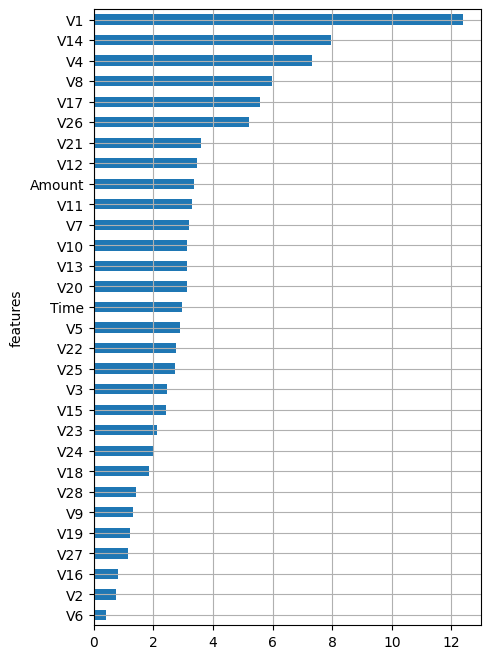

In [22]:
feature_names = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
                 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
                 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
fi = pd.DataFrame({'features': feature_names, 'w': model.feature_importances_})
fi.sort_values('w', inplace=True)
fi.set_index('features')['w'].plot(kind='barh', figsize=(5, 8), grid=True)

# Сделать прямой и обратный отбор фичей
## Сделать прямой и обратный отбор фичей
### Сделать прямой и обратный отбор фичей

In [26]:
y_pred = model.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


In [27]:
confusion_matrix(y_test, y_pred)

array([[93817,     8],
       [   33,   129]], dtype=int64)

Визуализируем несбалансированный датасет

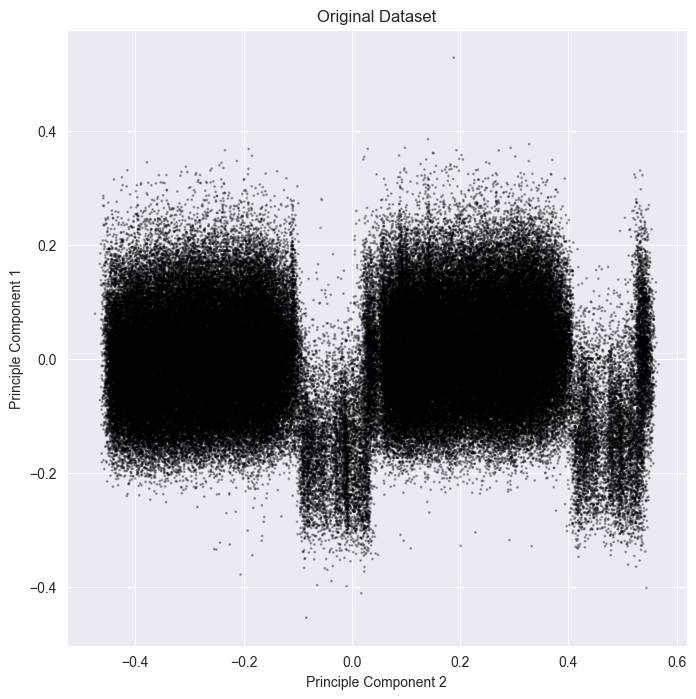

In [7]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

def plot_data(X, y, ax, title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3, s = 1, edgecolor=(0,0,0,0.5))
    ax.set_ylabel('Principle Component 1')
    ax.set_xlabel('Principle Component 2')
    if title is not None:
        ax.set_title(title)
        
fig,ax = plt.subplots(figsize=(8, 8))
plot_data(X_train_pca, y_train, ax, title='Original Dataset')

Применим Random Undersampling для класса большинства

In [8]:
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train_pca, y_train)

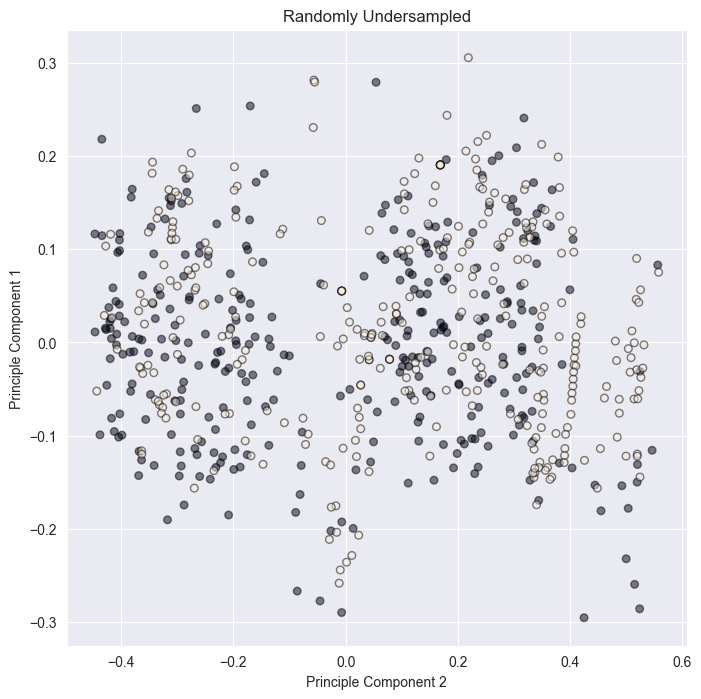

In [9]:
def plot_data(X, y, ax, title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(0,0,0,0.5))
    ax.set_ylabel('Principle Component 1')
    ax.set_xlabel('Principle Component 2')
    if title is not None:
        ax.set_title(title)
        
fig,ax = plt.subplots(figsize=(8, 8))
plot_data(X_train_rus, y_train_rus, ax, title='Randomly Undersampled')

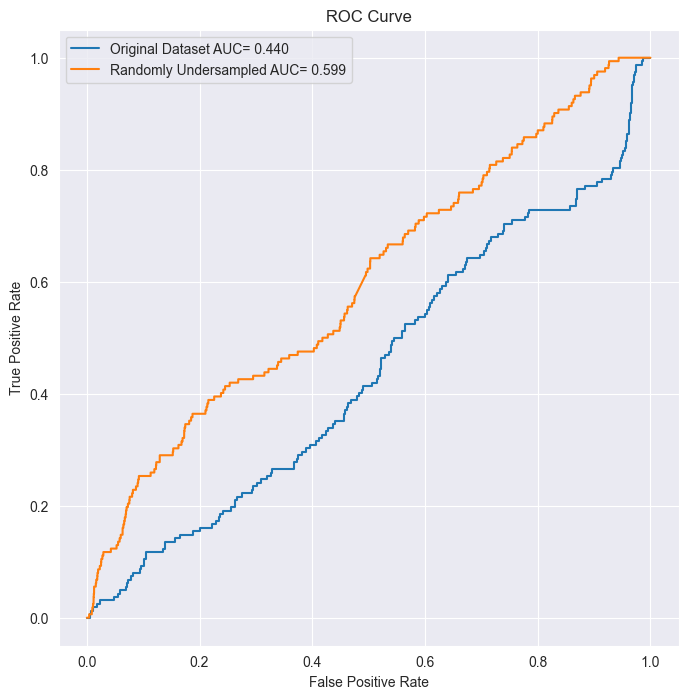

In [10]:
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    ax.plot(fpr, tpr, label=f'{title} AUC={auc: .3f}')
    
    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc=0)
    
fig,ax = plt.subplots(1, 1, figsize=(8, 8))
plot_roc(ax, X_train_pca, y_train, X_test_pca, y_test, 'Original Dataset')
plot_roc(ax, X_train_rus, y_train_rus, X_test_pca, y_test, 'Randomly Undersampled')

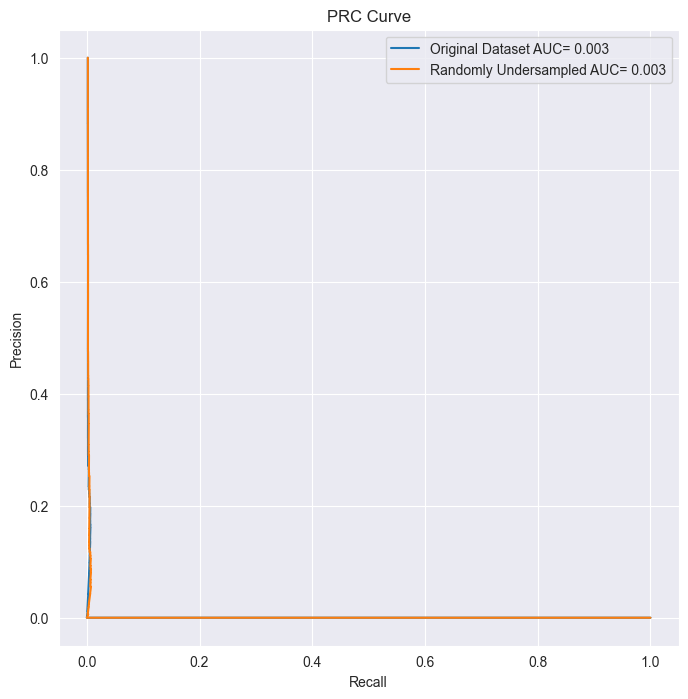

In [11]:
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)
    auc_prc = metrics.auc(recall, precision)
    ax.plot(precision, recall, label=f'{title} AUC={auc_prc: .3f}')
    
    ax.set_title('PRC Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc=0)
    
fig,ax = plt.subplots(1, 1, figsize=(8, 8))
plot_roc(ax, X_train_pca, y_train, X_test_pca, y_test, 'Original Dataset')
plot_roc(ax, X_train_rus, y_train_rus, X_test_pca, y_test, 'Randomly Undersampled')

ValueError: Found input variables with inconsistent numbers of samples: [190820, 93987]